In [1]:
from main import *

Using TensorFlow backend.


In [2]:
model = NN()

In [ ]:
model.train(1)

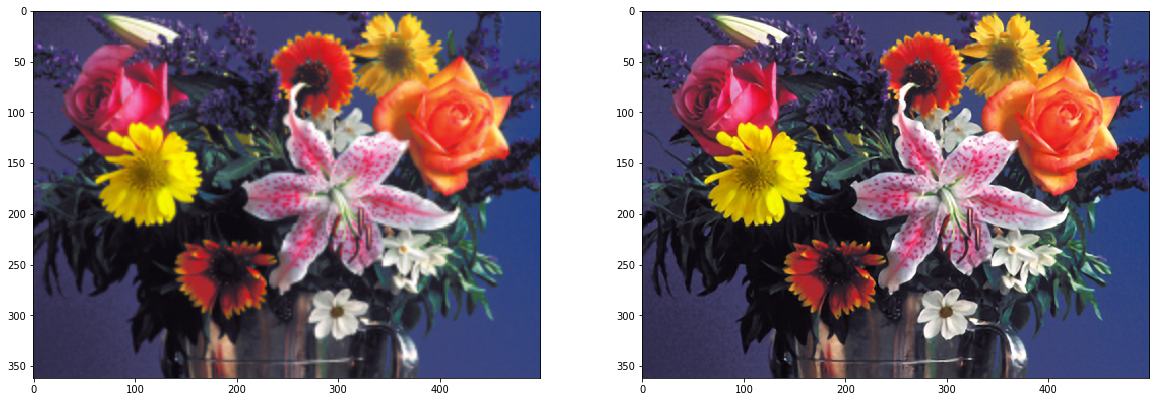

In [4]:
model.test_img(load_weights=True)

In [1]:
# from keras.models import Sequential
# from keras.layers import Conv2D, Input, BatchNormalization
from keras.layers import Input,Dropout
from keras.layers.convolutional import Conv2D
from keras.models import Sequential, Model, load_model

from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

import prepare_data as pd
import numpy as np
# import math
import matplotlib.pyplot as plt

import cv2

Using TensorFlow backend.


In [8]:
class NN():
    def __init__(self,epochs=200):
        self.epochs = epochs
        
        self.nn_train = self.build_nn()
        self.nn_test = self.build_nn(None,None)
        
    def build_nn(self,img_rows=32,img_cols=32):
        input_img = Input(shape=(img_rows,img_cols,1))
        x = Conv2D(filters=128,kernel_size=(9,9),kernel_initializer="glorot_uniform",
                   activation="relu",padding="valid",use_bias=True)(input_img)
        x = Dropout(0.2)(x,training=True)
        x = Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='glorot_uniform',
                   activation='relu', padding='same', use_bias=True)(x)
        x = Dropout(0.2)(x,training=True)
        output_img = Conv2D(filters=1, kernel_size=(5,5), kernel_initializer='glorot_uniform',
                     activation='linear',padding='valid', use_bias=True)(x)
        
        model_training = Model(input_img, output_img)
        adam = Adam(lr=0.0003)
        model_training.compile(optimizer=adam,loss="mean_squared_error",metrics=['mean_squared_error']) #self.custom_loss(log_noise))

#         self.model_out = Model(input_img,[output_img,log_noise])

        return model_training

    def train(self,batch_size=128):
        data, label = pd.read_training_data("./train.h5")
        val_data, val_label = pd.read_training_data("./test.h5")
        
        checkpoint = ModelCheckpoint("SRCNN_check.h5", monitor='val_loss', verbose=1, save_best_only=True,
                                     save_weights_only=False, mode='min')
        callbacks_list = [checkpoint]

        self.nn_train.fit(data, label, batch_size=batch_size, validation_data=(val_data, val_label),
                        callbacks=callbacks_list, shuffle=True, epochs=self.epochs) #, verbose=0)

        self.nn_train.save_weights("srcnn.h5")
        
    def test_img(self,img_name="./Test/Set14/flowers.bmp",load_weights=False):
        srcnn_model = self.nn_test
        
        if load_weights:
            srcnn_model.load_weights("srcnn_200.h5")
            
        IMG_NAME = img_name
        INPUT_NAME = "input.jpg"
        OUTPUT_NAME = "output.jpg"

        img = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb) ## BGR to YcrCb
        shape = img.shape
        Y_img = cv2.resize(img[:, :, 0], (shape[1] // 2, shape[0] // 2), cv2.INTER_CUBIC)
        Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
        img[:, :, 0] = Y_img
        img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
        cv2.imwrite(INPUT_NAME, img)
        
        fig,ax = plt.subplots(1,2,figsize=(20,20))

        ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        Y = np.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
        Y[0, :, :, 0] = Y_img.astype(float) / 255.
        pre = srcnn_model.predict(Y, batch_size=1) * 255.
        pre[pre[:] > 255] = 255
        pre[pre[:] < 0] = 0
        pre = pre.astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img[6: -6, 6: -6, 0] = pre[0, :, :, 0]
        img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)

        ax[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()

        cv2.imwrite(OUTPUT_NAME, img)

#         # psnr calculation:
#         im1 = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
#         im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
#         im2 = cv2.imread(INPUT_NAME, cv2.IMREAD_COLOR)
#         im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
#         im3 = cv2.imread(OUTPUT_NAME, cv2.IMREAD_COLOR)
#         im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]


#         print("bicubic:")
#         print(cv2.PSNR(im1, im2))
#         print("SRCNN:")
#         print(cv2.PSNR(im1, im3))

    def test(self,img_name="./Test/Set14/flowers.bmp",load_weights=False):
        srcnn_model = self.nn_test
        
        if load_weights:
#             srcnn_model.load_weights("srcnn_200_dropout.h5")
            srcnn_model.load_weights("srcnn_200.h5")
            
        IMG_NAME = img_name
        INPUT_NAME = "input.jpg"
        OUTPUT_NAME = "output.jpg"

        img = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb) ## BGR to YcrCb
        shape = img.shape
        Y_img = cv2.resize(img[:, :, 0], (shape[1] // 2, shape[0] // 2), cv2.INTER_CUBIC)
        Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
        img[:, :, 0] = Y_img
        img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
        cv2.imwrite(INPUT_NAME, img)
        
        fig,ax = plt.subplots(1,3,figsize=(20,20))
        ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        Y = np.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
        Y[0, :, :, 0] = Y_img.astype(float) / 255.
        
        T = 30
        var = np.zeros(img.shape)
        Ey = np.zeros(img.shape)
        
        for k in range(T):       
            pre = srcnn_model.predict(Y, batch_size=1) * 255.
            pre[pre[:] > 255] = 255
            pre[pre[:] < 0] = 0
            pre = pre.astype(np.uint8)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
            img[6: -6, 6: -6, 0] = pre[0, :, :, 0]
            img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
            
            var += (img/255)**2/T
            Ey += img/(T*255)
            
        var -= Ey**2
        var[var<0] = 0
        var *= 255
        var = var.astype(np.uint8)        
        
        ax[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        print(var.min(),var.max(),type(var))
        
        cb = ax[2].imshow(cv2.cvtColor(var, cv2.COLOR_BGR2RGB))
        
        fig.colorbar(cb,ax=ax,shrink=0.2,location="right")
        
        fig.savefig("./test")
        plt.show()

        cv2.imwrite(OUTPUT_NAME, img)
        
        return var

In [9]:
model = NN(5)

In [8]:
model.train()

Train on 14901 samples, validate on 420 samples
Epoch 1/5
14901/14901 [==============================] - 177s 12ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0057 - val_mean_squared_error: 0.0057

Epoch 00001: val_loss improved from inf to 0.00565, saving model to SRCNN_check.h5
Epoch 2/5
14901/14901 [==============================] - 148s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0038 - val_mean_squared_error: 0.0038

Epoch 00002: val_loss improved from 0.00565 to 0.00384, saving model to SRCNN_check.h5
Epoch 3/5
14901/14901 [==============================] - 145s 10ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0031 - val_mean_squared_error: 0.0031

Epoch 00003: val_loss improved from 0.00384 to 0.00314, saving model to SRCNN_check.h5
Epoch 4/5
14901/14901 [==============================] - 145s 10ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0028 - val_mean_squared_error: 0.0028

Epoch 00004: val_lo

0 22 <class 'numpy.ndarray'>


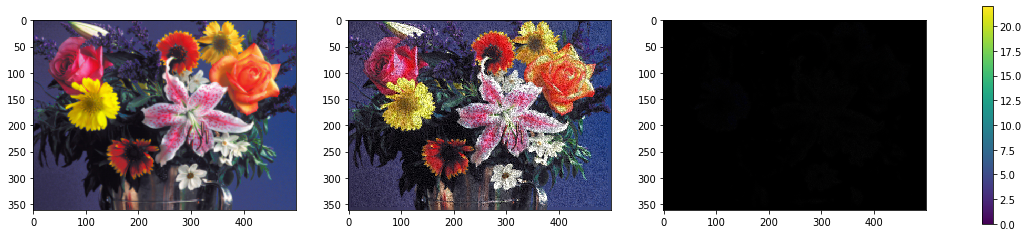

In [10]:
var = model.test(load_weights=True)

In [21]:
22/255

0.08627450980392157

In [11]:
var.shape

(362, 500, 3)

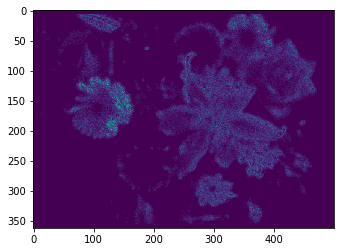

In [18]:
plt.imshow(var[:,:,0],vmin=0,vmax=22)

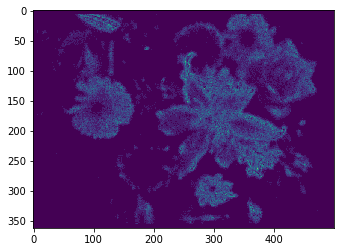

In [14]:
plt.imshow(var[:,:,1]/255)

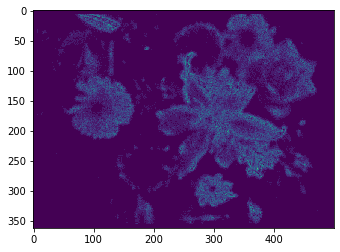

In [15]:
plt.imshow(var[:,:,2]/255)

In [9]:
srcnn_model = model.nn_test
srcnn_model.load_weights("srcnn_200.h5")
IMG_NAME = "./Test/Set14/flowers.bmp"
INPUT_NAME = "input2.jpg"
OUTPUT_NAME = "pre2.jpg"


img = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb) ## BGR to YcrCb
shape = img.shape
Y_img = cv2.resize(img[:, :, 0], (shape[1] // 2, shape[0] // 2), cv2.INTER_CUBIC)
Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
img[:, :, 0] = Y_img
img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
cv2.imwrite(INPUT_NAME, img)

True

In [10]:
print(img.shape,Y_img.shape)

(362, 500, 3) (362, 500)


(1, 362, 500, 1)
(1, 350, 488, 1)
(362, 500, 3)


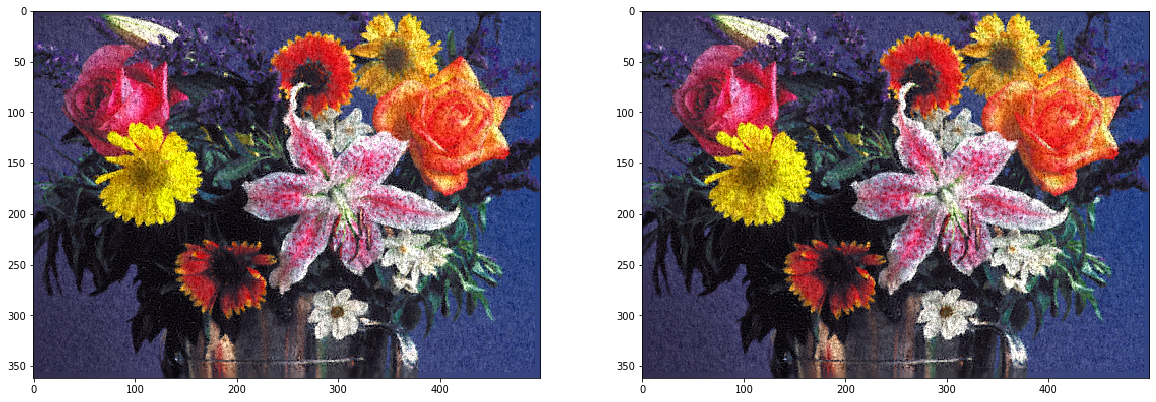

bicubic:
27.811886490022562
SRCNN:
22.637842259682127


In [12]:
fig,ax = plt.subplots(1,2,figsize=(20,20))

ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Y = np.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
Y[0, :, :, 0] = Y_img.astype(float) / 255.

print(Y.shape)

pre = srcnn_model.predict(Y, batch_size=1) * 255.

print(pre.shape)

pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

print(img.shape)

img[6: -6, 6: -6, 0] = pre[0, :, :, 0]
img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)

ax[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

cv2.imwrite(OUTPUT_NAME, img)

# psnr calculation:
im1 = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
im2 = cv2.imread(INPUT_NAME, cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
im3 = cv2.imread(OUTPUT_NAME, cv2.IMREAD_COLOR)
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]


print("bicubic:")
print(cv2.PSNR(im1, im2))
print("SRCNN:")
print(cv2.PSNR(im1, im3))